In [1]:
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import os;

dat = pd.DataFrame(columns=["Device","Mesh","Splitting","Shading","Coloring","Resolution","Framerates"]);
print(dat);

Empty DataFrame
Columns: [Device, Mesh, Splitting, Shading, Coloring, Resolution, Framerates]
Index: []


In [2]:
# We assume that we have a results_total directory that contains one directory per device that run the test, which in turn contains a directory for every model with each type of coloring which contains the results
# Example ./results_total/my_pc/drawing_wedge_tex.ply/uber_flat_960x540.csv
pth = "./results_total/"
devices = os.listdir("./results_total/");
for device in devices:
    for mesh_unparsed in os.listdir(pth + device):
        mesh = mesh_unparsed
        coloring = ""
        if(mesh.find("_col") != -1):
            mesh = mesh.replace("_col", "")
            coloring += "color"
        if(mesh.find("_tex") != -1):
            mesh = mesh.replace("_tex", "")
            coloring += "texture"
        if(mesh.find("_vert") != -1):
            mesh = mesh.replace("_vert", "")
            coloring = "vertex " + coloring
        if(mesh.find("_face") != -1):
            mesh = mesh.replace("_face", "")
            coloring = "face " + coloring
        if(mesh.find("_wedge") != -1):
            mesh = mesh.replace("_wedge", "")
            coloring = "wedge " + coloring
        for csv_file in os.listdir(pth + device + "/" + mesh_unparsed):
            splitting = ""
            shading = ""
            resolution = ""
            framerates = []
            for splits in ["uber", "split", "uber_static_if"]:
                if csv_file.find(splits) != -1:
                    splitting = splits
            for shad in ["flat", "smooth"]:
                if csv_file.find(shad) != -1:
                    shading = shad
            for res in ["960x540", "2560x1440"]:
                if csv_file.find(res) != -1:
                    resolution = res
            with open(pth + device + "/" + mesh_unparsed + "/" + csv_file) as f:
                file_string = f.read()
                framerates = [float(x) for x in file_string.split("\n") if x!=""]
            dat = pd.concat([dat, pd.DataFrame([[device,mesh,splitting,shading,coloring,resolution,framerates]], columns=dat.columns)], ignore_index=True)





        

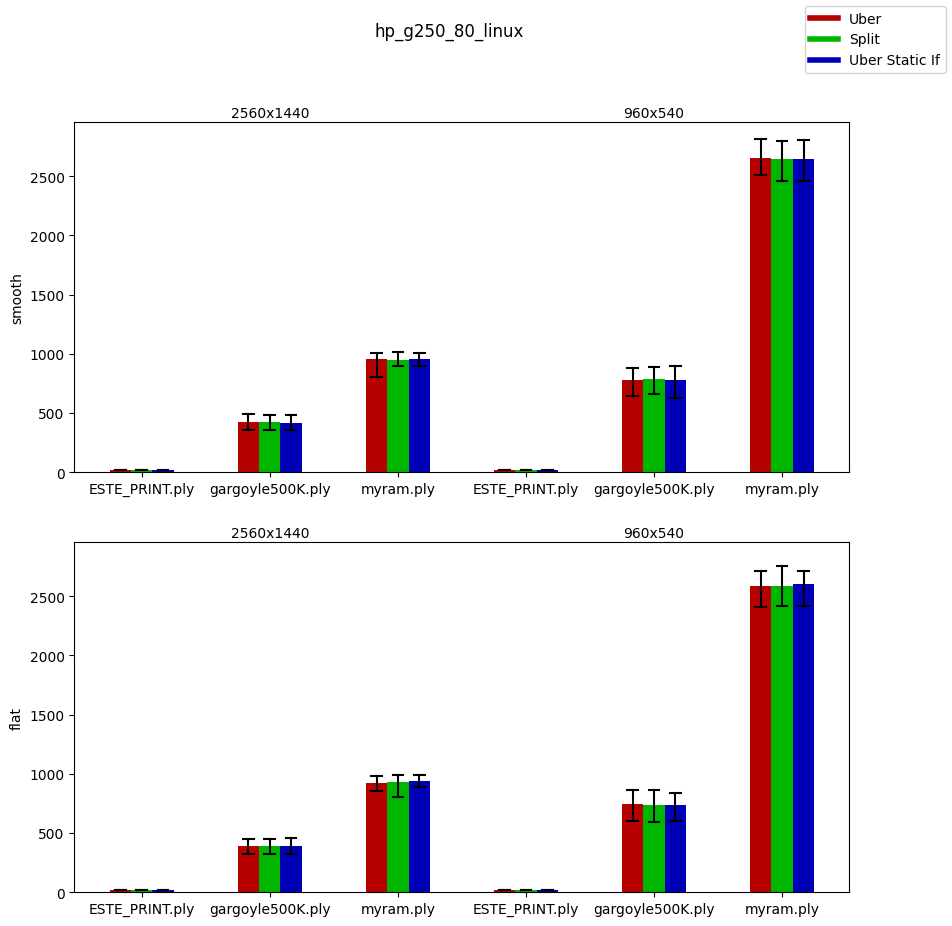

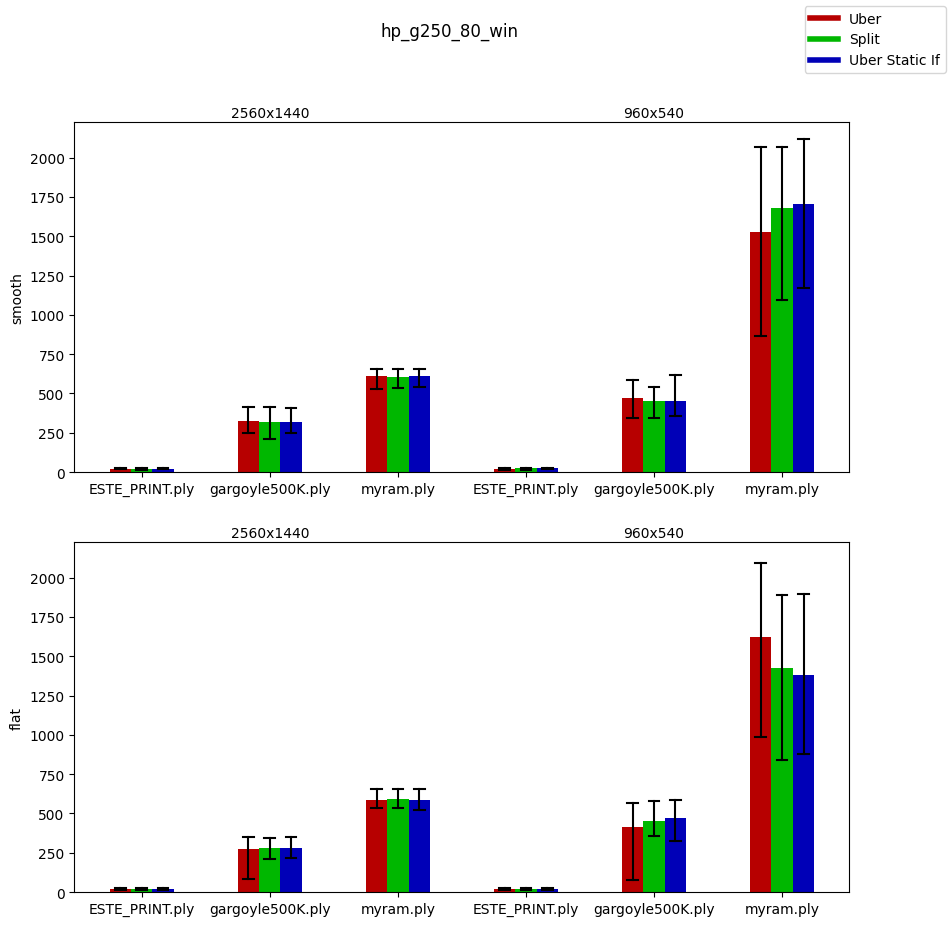

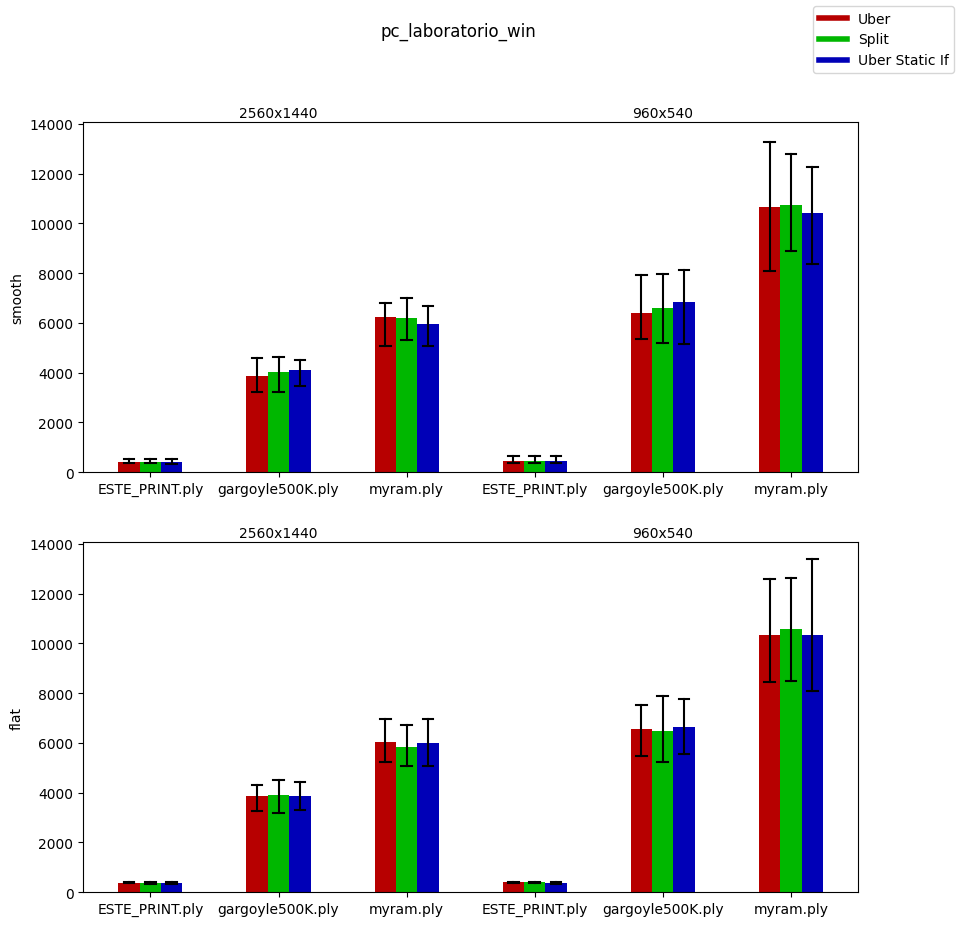

In [88]:
def grouped_hists(dataset: pd.DataFrame, device: str, meshes: list[str], resolutions: list[str], starting_x = 10, bar_w = 10, group_dist = 30, colors = ["#b70000","#00b700","#0000b7"]):
    filtered = dataset[dataset.Device == device]
    fig = plt.figure(figsize=(10,10))
    fig.legend(handles = [plt.Line2D([0],[0],color=colors[0],linewidth=4),plt.Line2D([0],[0],color=colors[1],linewidth=4),plt.Line2D([0],[0],color=colors[2],linewidth=4)],labels = ["Uber", "Split", "Uber Static If"])
    axs = fig.subplots(2, 1)
    max_height = 0
    center_bars_dist = group_dist+3*bar_w
    xticks_locs = np.arange(bar_w+starting_x, bar_w+starting_x+center_bars_dist*5+1, center_bars_dist).tolist()
    xticks_labels = meshes.tolist()*2
    for (i,shad) in enumerate(["smooth", "flat"]):
        current_x = starting_x
        ax: plt.Axes = axs[i]
        ax.set_xticks(xticks_locs)
        ax.set_xticklabels(xticks_labels)
        ax.set_ylabel(shad)
        temp_dat = filtered[filtered.Shading == shad]
        for (j, resolution) in enumerate(resolutions):
            tempp = temp_dat[temp_dat.Resolution == resolution]
            for mesh in meshes:
                temp_dat2 = tempp[tempp.Mesh == mesh]
                for (k, splits) in enumerate(["uber", "split", "uber_static_if"]):
                    temp_dat3 = temp_dat2[temp_dat2.Splitting == splits]
                    arr = [x for y in temp_dat3["Framerates"].to_numpy().flatten() for x in y]
                    mn = np.min(arr)
                    mx = np.max(arr)
                    bar_h = np.mean(arr)
                    max_height = max([max_height, np.max(arr)])
                    ax.bar(current_x, bar_h, 10, color=colors[k])
                    ax.plot([current_x, current_x],[mx, mn], color="#000000")
                    ax.plot([current_x-bar_w/4,current_x+bar_w/4],[mx, mx], color="#000000")
                    ax.plot([current_x-bar_w/4,current_x+bar_w/4],[mn, mn], color="#000000")
                    current_x += bar_w
                current_x += group_dist
    for ax in axs:
        ax.set_ybound(0, 1.05*max_height)
        x0, y0, w, h = ax.get_position().bounds
        l, r = ax.get_xlim()
        for (i, resolution) in enumerate(resolutions):
            garg5kloc = (xticks_locs[1+3*i]-l)/(r-l)
            relativeToFig = garg5kloc*w + x0
            fig.text(relativeToFig, y0+h+0.005, resolution, ha="center")
    fig.suptitle(device)
    plt.show()

for device in dat["Device"].unique():
    grouped_hists(dat, device, dat["Mesh"].unique(), dat["Resolution"].unique())
    